In [16]:
import os
import fastparquet
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
from glob import glob

In [17]:
def get_width(A):
    """
    Get width for every x-value.

    Parameters
    ----------
    A : ndarray
        array of shape n x 3 with cols: 'X','Y','Z'

    Returns
    -------
    ux : ndarray
        all unique x 
    w : ndarray
        widths of each profile
    """

    # get unique x values
    ux = np.unique(A[:,0])

    # get width at each ux
    w = []
    for i in ux:
        mask = (A[:,0] == i)
        y = A[mask,1]
        w.append(np.max(y) - np.min(y))
    w = np.array(w)
    return ux, w

In [18]:
def get_height(A0,A1):
    """
    Get height between two layers for every slice.

    Parameters
    ----------
    A0 : ndarray
        lower layer array of shape n x 3 with cols: 'X','Y','Z'
    A1 : ndarray
        upper layer array of shape n x 3 with cols: 'X','Y','Z'

    Returns
    -------
    ux : ndarray
        all unique x 
    h : ndarray
        true height of new layer
    """

    # get unique x values that are in both layers
    ux0 = np.unique(A0[:,0])
    ux1 = np.unique(A1[:,0])
    ux = np.intersect1d(ux0,ux1)

    # get height at each ux
    h = []
    for i in ux:
        # get slice of lower layer
        mask0 = (A0[:,0] == i)
        z0 = A0[mask0,2]
        
        # get slice of upper layer
        mask1 = (A1[:,0] == i) 
        z1 = A1[mask1,2]

        # get height of layer
        height = np.max(z1) - np.max(z0)

        # append results to list
        h.append(height)

    # convert list to array
    h = np.array(h)

    return ux, h

In [19]:
def get_shift(A0,A1):
    """
    Get shift of weld bead top (y-Direction).

    Parameters
    ----------
    A0 : ndarray
        lower layer array of shape n x 3 with cols: 'X','Y','Z'
    A1 : ndarray
        upper layer array of shape n x 3 with cols: 'X','Y','Z'

    Returns
    -------
    ux : ndarray
        all unique x 
    dy : ndarray
        delta y of new layer compared to previous layer
    """

    # get unique x values that are in both layers
    ux0 = np.unique(A0[:,0])
    ux1 = np.unique(A1[:,0])
    ux = np.intersect1d(ux0,ux1)

    # get shift at each ux
    dy = []
    for i in ux:
        # get slice of lower layer
        mask0 = (A0[:,0] == i)
        y0,z0 = A0[mask0,1],A0[mask0,2]
        
        # get slice of upper layer
        mask1 = (A1[:,0] == i) 
        y1,z1 = A1[mask1,1],A1[mask1,2]

        # get delta y of weld bead tops
        delta_y = y1[np.argmax(z1)] - y0[np.argmax(z0)]
        
        # append results to list
        dy.append(delta_y)

    # convert list to array
    dy = np.array(dy)

    return ux, dy

# load data

In [20]:
if __name__ ==  '__main__': 
    # get time for performance monitoring
    t0 = time.time()

    # load first scan 
    data_dir_A = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01"
    npy_files_A = glob(os.path.join(data_dir_A, "layer***.npy"))
    with Pool(processes=len(npy_files_A)) as pool:
        npy_list_A = pool.map(np.load, npy_files_A)

    # load second scan
    data_dir_B = r"C:\Users\mie\Documents\GIT_Repositories\scan_analyze\data\V01"
    npy_files_B = glob(os.path.join(data_dir_B, "layer***.npy"))
    with Pool(processes=len(npy_files_B)) as pool:
        npy_list_B = pool.map(np.load, npy_files_B)

    # time
    print('read finished after: ' + str(np.round(time.time()-t0, 1)) + ' s')

read finished after: 1.4 s


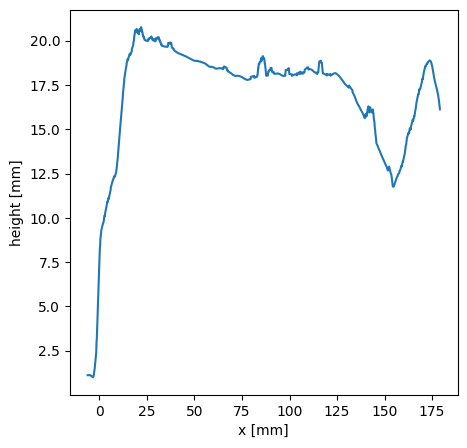

In [21]:
##### HEIGHT #####
layer0 = 1-1 # lower layer
layer1 = -1 # upper layer

A0 = np.round(npy_list_A[layer0],3) # lower layer 
A1 = np.round(npy_list_A[layer1],3) # upper layer

# get layer heights
ux,h = get_height(A0,A1)

# test: rolling mean
N = 19
rm = np.convolve(h, np.ones(N)/N, mode='valid')

# Create plot
fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(ux,h)
ax.plot(ux[9:-9],rm) # plot rolling mean
# ax.scatter(A0[:,0],A0[:,2]) # lower layer
# ax.scatter(A1[:,0],A1[:,2]) # upper layer
ax.set_xlabel('x [mm]')
ax.set_ylabel('height [mm]')
plt.show()

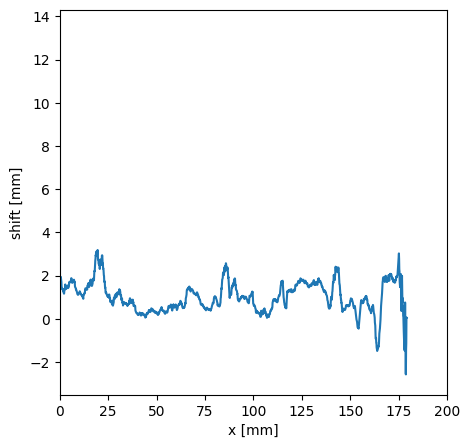

In [24]:
##### SHIFT ##### 
##### offset of weld bead top in yDir #####
ux,dy = get_shift(A0,A1)

# test: rolling mean
N = 19
rm = np.convolve(dy, np.ones(N)/N, mode='valid')

# Create plot
fig, ax = plt.subplots(figsize=(5,5))
# ax.plot(ux,dy)
ax.plot(ux[9:-9],rm)
ax.set_xlabel('x [mm]')
ax.set_ylabel('shift [mm]')
ax.set_xlim(0,200)
plt.show()

# compare two scans

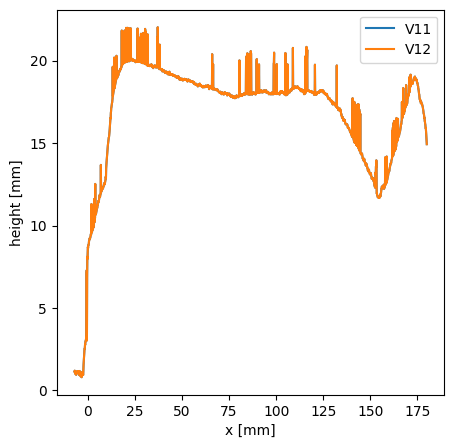

In [26]:
##### HEIGHT #####
layer0 = 1-1 # lower layer
layer1 = -1 # upper layer

# get scan A
A0 = np.round(np.array(npy_list_A[layer0]),3)
A1 = np.round(np.array(npy_list_A[layer1]),3)

# get scan B
B0 = np.round(np.array(npy_list_B[layer0]),3)
B1 = np.round(np.array(npy_list_B[layer1]),3)

# get layer heights
uxA,hA = get_height(A0,A1)
uxB,hB = get_height(B0,B1)

# # crop scan A
# mask = (uxA>50)&(uxA<175)
# uxA,hA = uxA[mask],hA[mask]

# # crop scan B
# mask = (uxB>50)&(uxB<175)
# uxB,hB = uxB[mask],hB[mask]

# Create plot
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(uxA,hA)
ax.plot(uxB,hB)
ax.set_xlabel('x [mm]')
ax.set_ylabel('height [mm]')
legend_labels = ['V11','V12']
plt.legend(legend_labels)
plt.show()
fig.savefig(str(data_dir_A[-3:]+'_'+data_dir_B[-3:]+'_h_over_x.svg'), format='svg')

# analyse median width & height

In [27]:
def get_median_width_height(npy_list):
    """
    Get median width and height for each layer

    Parameters
    ----------
    npy_list : list
        list of arrays with cols: 'X','Y','Z'

    Returns
    -------
    w : ndarray
        median width of each layer
    h : ndarray
        median height of each layer    
        """

    # make empty lists for values
    w = []
    h = []

    for i in range(0,len(npy_list)):
        layer0 = i-1 # lower layer
        layer1 = i # upper layer

        # get arrays
        if layer0 == -1:
            A0 = np.round(np.array(npy_list[layer1]),3)
            A0[:,2] = 1 # asume height of base plate is z=1 mm
        else:
            A0 = np.round(np.array(npy_list[layer0]),3)
        A1 = np.round(np.array(npy_list[layer1]),3)

        # crop data in x-direction
        xMin,xMax = 50,120
        A0 = A0[(A0[:,0]>xMin) & (A0[:,0]<xMax)] # Bsp.: X>50
        A1 = A1[(A1[:,0]>xMin) & (A1[:,0]<xMax)]

        # get width & height
        ux,width = get_width(A1)
        ux,height = get_height(A0,A1)

        # ##### TEST #####
        # # Create plot
        # fig, ax = plt.subplots(figsize=(5,5))
        # ax.plot(ux,height)
        # plt.show()

        # get median
        median_w = np.median(width)
        median_h = np.median(height)

        # append median to list
        w.append(median_w)
        h.append(median_h)

        #print progress
        print(str(i+1) + '/' + str(len(npy_list)))

    return w,h

In [28]:
w,h = get_median_width_height(npy_list_A)

1/15
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15


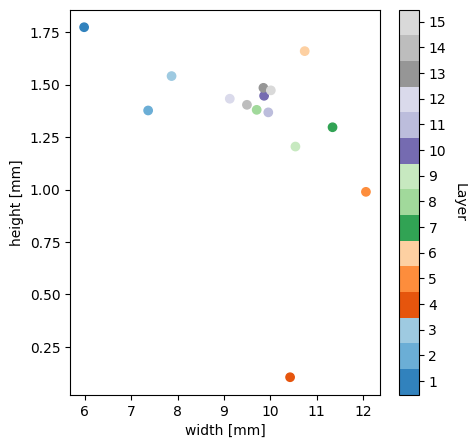

In [37]:
from matplotlib.colors import ListedColormap

# scatter plot
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

# create a new colormap with 15 colors based on tab20
cmap = plt.get_cmap('tab20c')
new_cmap = ListedColormap(cmap(np.linspace(0, 1, len(w))))

scatter_plot = ax.scatter(w,h,c=np.arange(len(w)),cmap=new_cmap,
                          label=np.arange(len(w)))

# custom colorbar
colorbar = plt.colorbar(scatter_plot)
colorbar.set_label('Layer', rotation=270, labelpad=15)
colorbar.set_ticks(np.arange(0, len(w))*(len(w)-1)/len(w)+0.5)
colorbar.set_ticklabels(np.arange(0, len(w))+1)

ax.set_xlabel('width [mm]')
ax.set_ylabel('height [mm]')
plt.show()
fig.savefig(str(data_dir_A[-3:]+'_hw.svg'), format='svg')

# save median data to a table
wh = np.column_stack((np.array(w),np.array(h)))
np.save(data_dir_A + '\\wh.npy',wh)

df = pd.DataFrame(wh)
df = df.rename(columns={df.columns[0]: 'width',df.columns[1]: 'height'})
df.to_csv(data_dir_A + '\\wh.csv', index=False)